# Investigate Salt Flux within Delaware Bay Estuary

## Load packages

In [1]:
# Import relevant packages
import xarray as xr
import xarray.ufuncs as xu
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cmocean as cm
import dask.array as da
from IPython import display

#### Publication Link: Pareja et al 2019 <a>https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2018JC014585<a>

In [2]:
from dask.distributed import Client

In [ ]:
client = Client()

In [ ]:
client

#### This version I got from https://stackoverflow.com/questions/62797088/xr-apply-ufunc-to-filter-3d-x-array

In [ ]:
from scipy import signal

In [ ]:
Cf = 32
fs = 1
order_butter=6

In [ ]:
def butter_filt(x,Cf,fs,order_butter):
    #Cf = is the half amplitude in hours
    #fs = is the sample interval in hours
    #fn = fs/2; # Nyquist Frequency
    fc = (1/Cf)/2 # cut off frequency
    b, a = signal.butter(order_butter, fc, 'low', fs=fs, output='ba')

    return signal.filtfilt(b, a, x)


def filtfilt_butter(x,Cf,fs,order_butter,dim='ocean_time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function    
    filt= xr.apply_ufunc(
        butter_filt,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        Cf,  # as above
        fs,  # as above
        order_butter,  # as above
        input_core_dims=[["depth","km","time"], [], [],[]],  # list with one entry per arg
        output_core_dims=[["depth","km","time"]],  # returned data has 3 dimension
        exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True)  # loop over non-core dims)

    return filt

## Load Model Data

In [ ]:
## CHUNKING TO 100 ; ds['salt'] ~ 1.61 GB chunks - didn't work
## CHUNKING TO 80 ; ds['salt'] ~ 1.29 GB chunks - didn't work
## CHUNKING TO 60 ; ds['salt'] ~ 967 MB chunks - didn't work
## CHUNKING TO 50 ; ds['salt'] ~ 806 MB chunks - didn't work
## CHUNKING TO 40 ; ds['salt'] ~ 645 MB chunks - didn't work
## CHUNKING TO 30 ; ds['salt'] ~ 484 MB chunks - didn't work
## CHUNKING TO 20 ; ds['salt'] ~ 322 MB chunks - didn't work
## CHUNKING TO 10 ; ds['salt'] ~ 161 MB chunks - some distributed memory issues
## CHUNKING TO 8 ; ds['salt'] ~ 130 MB chunks 
## CHUNKING TO 5 ; ds['salt'] ~ 80 MB chunks 

ds = xr.open_mfdataset('/vortexfs1/share/usgs-share/users/scook/proj/DE_Bay/run07/run07C/testcoawst/bulk_waves/ocean_deb_his_run07C_testcoawst_waves_000*.nc',
                       concat_dim='ocean_time',
                       data_vars='minimal', coords='minimal', compat='override',
                       parallel=True, chunks={'ocean_time':5})

In [ ]:
ds

#### Calculate vertical positions z_r and z_w
display.Image("https://www.myroms.org/wiki/images/4/41/vertical_grid.png")

In [ ]:
N = len(ds['s_rho'])
dx = 1/ds['pm']
dy = 1/ds['pn']
h = ds['h']
hc = ds['hc']
Np = N+1
dss = 1/N
theta_s = ds['theta_s']
theta_b = ds['theta_b']
s_rho = ds['s_rho']

In [ ]:
# Calculate Stretching - but if theta_s and theta_b are 0 I think s=s_rho and C=Cs_r
# RHO POINTS
Nlev = N
lev = np.arange(1,N+1)-0.5
sr = (lev-N)*dss
sr = xr.DataArray(sr,dims=['s_rho'],coords={'s_rho':ds['s_rho']})
        
if theta_s>0:
    Csur=(1.0-cosh(theta_s*s))/(cosh(theta_s)-1.0)
else:
    Csur=-sr**2;

if (theta_b > 0):
    Cbot=(exp(theta_b*Csur)-1.0)/(1.0-exp(-theta_b))
    C=Cbot;
else:
    C=Csur

Cr = xr.DataArray(C,dims=['s_rho'],coords={'s_rho':ds['s_rho']})

Zo_rho = ( ds.hc * sr + Cr * ds.h ) / ( ds.hc + ds.h )
z_rho  = ds.zeta + ( ds.zeta + ds.h ) * Zo_rho
ds.coords['z_rho'] = z_rho.transpose()

In [ ]:
# Calculate Stretching - but if theta_s and theta_b are 0 I think s=s_rho and C=Cs_
# W POINTS
Nlev = Np
lev = np.arange(0,Nlev)
sw = (lev-N)*dss
sw = xr.DataArray(sw,dims=['s_w'],coords={'s_w':ds['s_w']})
        
if theta_s > 0:
    Csur=(1.0-cosh(theta_s*s))/(cosh(theta_s)-1.0)
else:
    Csur=-sw**2;

if (theta_b > 0):
    Cbot=(exp(theta_b*Csur)-1.0)/(1.0-exp(-theta_b))
    C=Cbot;
else:
    C=Csur
    
Cw = xr.DataArray(C,dims=['s_w'],coords={'s_w':ds['s_w']})

Zo_w = ( ds.hc * sw + Cw * ds.h ) / ( ds.hc + ds.h )
z_w  = ds.zeta + ( ds.zeta + ds.h ) * Zo_w
ds.coords['z_w'] = z_w.transpose()

## Establish the indices for mouth transect - this will lower calculation time down the road

In [13]:
x = np.arange(48,108,1)
y = np.arange(57,69,1)
y = np.repeat(y,5)

In [14]:
print(len(x),len(y))

60 60


In [15]:
target_x = xr.DataArray(x,dims=["points"])
target_y = xr.DataArray(y,dims=["points"])

#### Calculate Hz - cell thickness

In [16]:
dz = ds['z_w'].isel(xi_rho=target_x,eta_rho=target_y).compute()

In [17]:
Hz = dz.diff(n=1,dim='s_w').swap_dims({'s_w':'s_rho'})

#### Calculate dx - cell width

In [18]:
dx =  1/ds['pm'].isel(xi_rho=target_x,eta_rho=target_y).compute()

#### Calculate Area

In [19]:
dA = dx*Hz

In [20]:
Ao = xr.apply_ufunc(filtfilt_butter,
                   (dA.sum(axis=0).sum(axis=0)).chunk(dict(ocean_time=-1)),
                   Cf,
                   fs,
                   order_butter,
                   'ocean_time', 
                   dask='parallelized',
                   #vectorize=True,
                   #allow_rechunk=True,
                   input_core_dims=[["ocean_time"],[],[],[],[]],  # list with one entry per arg
                   output_core_dims=[["ocean_time"]],  # returned data has one dimension   
                   output_dtypes=[Hz.dtype])  # one per output

In [21]:
dAo = xr.apply_ufunc(filtfilt_butter,
                   dA.chunk(dict(ocean_time=-1)),
                   Cf,
                   fs,
                   order_butter,
                   'ocean_time', 
                   dask='parallelized',
                   #vectorize=True,
                   #allow_rechunk=True,
                   input_core_dims=[["ocean_time"],[],[],[],[]],  # list with one entry per arg
                   output_core_dims=[["ocean_time"]],  # returned data has one dimension   
                   output_dtypes=[Hz.dtype])  # one per output

In [22]:
nt = len(ds['ocean_time'])

In [23]:
si = ds['salt'].isel(xi_rho=target_x,eta_rho=target_y).chunk({'ocean_time':nt}).persist()

si = ds['salt'].isel(xi_rho=target_x,eta_rho=target_y).chunk({'ocean_time':nt}).compute()

In [24]:
vi = ds['v'].isel(xi_v=target_x,eta_v=target_y).chunk({'ocean_time':nt}).persist()

In [25]:
zi = ds['zeta'].isel(xi_rho=target_x,eta_rho=target_y).chunk({'ocean_time':nt}).persist()

In [26]:
ds.close()

# Calculate Salt Flux

$ \LARGE F_s = \left\langle \iint v s \, \mathrm{d}A \right\rangle $

### River 
$ \large v_0 (t) = \frac{1}{A_0} \left\langle \iint v(x,z,t) \,  \mathrm{d}A \right\rangle \\
\large s_0 (t) = \frac{1}{A_0} \left\langle \iint s(x,z,t) \,  \mathrm{d}A \right\rangle$

the persist() from above might affect this computation...

In [27]:
v0i = (vi*dA).sum(axis=1).sum(axis=1)
s0i = (si*dA).sum(axis=1).sum(axis=1)

In [28]:
Cf = 32
fs = 1
order_butter=6
v0 = butter_filt(v0i,Cf,fs,order_butter)/Ao
s0 = butter_filt(s0i,Cf,fs,order_butter)/Ao

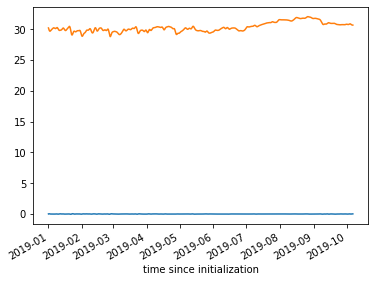

In [29]:
v0.plot()
s0.plot()

$\large F_0 = -v_0 \, \, \iint \mathrm{d}A_0 \, {d}x {d}z \, \, s_0\\
\large F_0 = - Q_0 \, s_0$

In [30]:
F0 = -1*v0*dAo.sum(axis=0).sum(axis=0)*s0

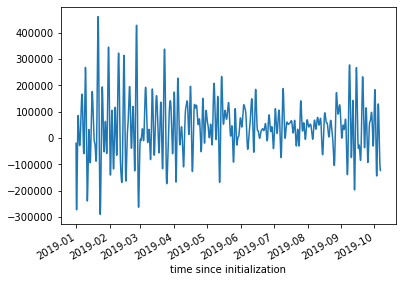

In [31]:
F0.plot()

### Exchange Flow
$ \large v_e (x,z,t) = \frac{\left\langle v \, \mathrm{d}A \right\rangle}{dA_0}  - v_0 \\
\large s_e (x,z,t) = \frac{\left\langle s \, \mathrm{d}A \right\rangle}{dA_0}  - v_0 $

In [32]:
vei = xr.apply_ufunc(filtfilt_butter,
                   (vi*dA).chunk(dict(ocean_time=-1)),
                   Cf,
                   fs,
                   order_butter,
                   'ocean_time', 
                   dask='parallelized',
                   #vectorize=True,
                   #allow_rechunk=True,
                   input_core_dims=[["ocean_time"],[],[],[],[]],  # list with one entry per arg
                   output_core_dims=[["ocean_time"]],  # returned data has one dimension   
                   output_dtypes=[Hz.dtype])  # one per output

In [33]:
sei = xr.apply_ufunc(filtfilt_butter,
                   (si*dA).chunk(dict(ocean_time=-1)),
                   Cf,
                   fs,
                   order_butter,
                   'ocean_time', 
                   dask='parallelized',
                   #vectorize=True,
                   #allow_rechunk=True,
                   input_core_dims=[["ocean_time"],[],[],[],[]],  # list with one entry per arg
                   output_core_dims=[["ocean_time"]],  # returned data has one dimension   
                   output_dtypes=[Hz.dtype])  # one per output

In [34]:
ve=vei/dAo-v0
se=sei/dAo-s0

In [35]:
Fe = (ve*se*dAo.sum(axis=0).sum(axis=0)).sum(axis=0).sum(axis=0)

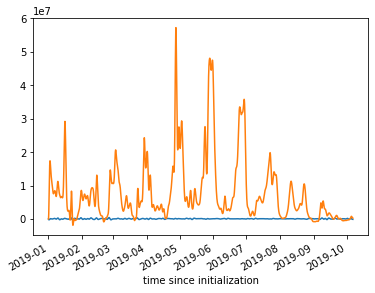

In [36]:
F0.plot()
Fe.plot()

### Tidal Shear Dispersion
$ \large v_t (x,z,t) = v-v_e -v_0 \\
\large s_t (x,z,t) = s-s_e -s_0$

In [37]:
vt = vi-ve-v0;
st = si-se-s0;

In [38]:
Ft = ((vt*st*dAo.sum(axis=0).sum(axis=0)).sum(axis=1).sum(axis=1)).compute()

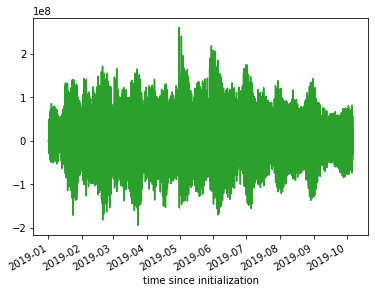

In [39]:
F0.plot()
Fe.plot()
Ft.plot()

### Salt Flux
$ \large F_s = \left\langle \iint v s \, \mathrm{d}A \right\rangle $

In [40]:
Fsi = (v0*s0)+(ve*se)+(vt*st)

In [41]:
Fsi

<xarray.DataArray (ocean_time: 6688, s_rho: 16, points: 60)>
dask.array<add, shape=(6688, 16, 60), dtype=float64, chunksize=(6688, 16, 60), chunktype=numpy.ndarray>
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2019-01-01 ... 2019-10-06T15:00:00
  * s_rho       (s_rho) float64 -0.9688 -0.9062 -0.8438 ... -0.09375 -0.03125
    lon_v       (points) float64 dask.array<chunksize=(60,), meta=np.ndarray>
    lat_v       (points) float64 dask.array<chunksize=(60,), meta=np.ndarray>
    lon_rho     (points) float64 -75.1 -75.09 -75.09 ... -74.96 -74.95 -74.95
    lat_rho     (points) float64 38.8 38.8 38.81 38.81 ... 38.94 38.94 38.94
    s_w         (s_rho) float64 -0.9375 -0.875 -0.8125 ... -0.125 -0.0625 0.0
    z_w         (s_rho, points, ocean_time) float64 dask.array<chunksize=(16, 60, 6688), meta=np.ndarray>
    z_rho       (s_rho, points, ocean_time) float64 dask.array<chunksize=(16, 60, 6688), meta=np.ndarray>
Dimensions without coordinates: points

In [42]:
Fsii = ((Fsi*Hz).sum(dim='s_rho')*dx).sum(dim='points')

In [43]:
Cf = 32
fs = 1
order_butter=6
Fs = butter_filt(Fsii,Cf,fs,order_butter)

In [44]:
Fs = xr.apply_ufunc(filtfilt_butter,
                   Fsii.chunk(dict(ocean_time=-1)),
                   Cf,
                   fs,
                   order_butter,
                   'ocean_time', 
                   dask='parallelized',
                   #vectorize=True,
                   #allow_rechunk=True,
                   input_core_dims=[["ocean_time"],[],[],[],[]],  # list with one entry per arg
                   output_core_dims=[["ocean_time"]],  # returned data has one dimension   
                   output_dtypes=[Hz.dtype])  # one per output

In [45]:
Fs

<xarray.DataArray (ocean_time: 6688)>
dask.array<transpose, shape=(6688,), dtype=float64, chunksize=(6688,), chunktype=numpy.ndarray>
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2019-01-01 ... 2019-10-06T15:00:00

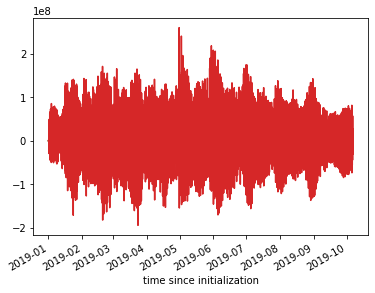

In [46]:
plt.plot(ds['ocean_time'],-1*Fs)
F0.plot()
Fe.plot()
Ft.plot()

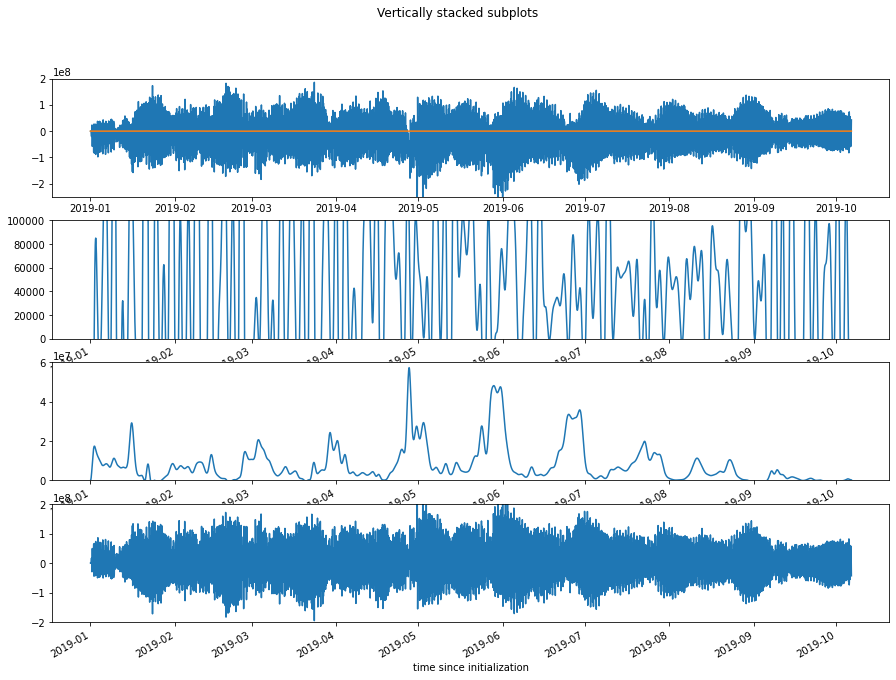

In [47]:
fig, axs = plt.subplots(4,figsize=(15,10))
fig.suptitle('Vertically stacked subplots')
axs[0].plot(ds['ocean_time'],-1*(F0+Fe+Ft))
axs[0].plot(ds['ocean_time'],-1*Fs)

axs[0].set_ylim([-250000000, 200000000])
F0.plot(ax=axs[1],         ylim=[0,    100000])
Fe.plot(ax=axs[2],         ylim=[0,  60000000])
Ft.plot(ax=axs[3],ylim=[-200000000, 200000000])

In [49]:
ds_waves = xr.Dataset({})
ds_waves['Fs']=-1*(F0+Fe+Ft)
ds_waves['F0']=-1*F0
ds_waves['Fe']=Fe
ds_waves['Ft']=Ft
ds_waves['time']=ds['ocean_time']


In [50]:
ds_waves

<xarray.Dataset>
Dimensions:     (ocean_time: 6688)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2019-01-01 ... 2019-10-06T15:00:00
Data variables:
    Fs          (ocean_time) float64 dask.array<chunksize=(6688,), meta=np.ndarray>
    F0          (ocean_time) float64 dask.array<chunksize=(6688,), meta=np.ndarray>
    Fe          (ocean_time) float64 dask.array<chunksize=(6688,), meta=np.ndarray>
    Ft          (ocean_time) float64 -158.7 1.776e+05 ... -2.644e+07 -4.295e+07
    time        (ocean_time) datetime64[ns] 2019-01-01 ... 2019-10-06T15:00:00

In [ ]:
ds_waves.to_netcdf("Salt_Flux_2019_testcoawst_waves.nc")